## Optiver Competition 
Team: Brandon, Jatindeep, Alex, Avi

**Overview:** I created a Jupyter notebook from our last notebook where we can develop models here and test the MAE since it takes hours on Kaggle. After we develop some solid models, we can then submit them on kaggle. We will automatically start with the 50 features, as well as the targets. And go from there. Feel free to add visualization as it will help us better understand the models responses to our changes.

Disregard Principal Component Analysis for now

## New Features and Model Setup
- This is the code I pulled from the other notebook mixed with all of our stuff. The goal is to beat our first model MAE of 6.41
- I will first begin with just the new features
- First up is feature engineering

In [2]:
import pandas as pd
import numpy as np
import catboost as cbt
import xgboost as xgb
import lightgbm as lgb
import gc
from itertools import combinations
import warnings
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from warnings import simplefilter
import joblib
from tqdm import tqdm

#Filtering some warnings (we might wanna look at the performance one maybe)
warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)



#Read data, calculate median, std_deviation of total bid + sizes, get target
train = pd.read_csv('train.csv')
median_sizes = train.groupby('stock_id')['bid_size'].median() + train.groupby('stock_id')['ask_size'].median()
std_sizes = train.groupby('stock_id')['bid_size'].std() + train.groupby('stock_id')['ask_size'].std()
train = train.dropna(subset=['target'])

#The author's feature engineering. Could work well we could potentially improve and combine from last notebook if there are any differences
def feat_eng(df):
    
    cols = [c for c in df.columns if c not in ['row_id', 'time_id']]
    df = df[cols]
    df['imbalance_ratio'] = df['imbalance_size'] / df['matched_size']
    df['bid_ask_volume_diff'] = df['ask_size'] - df['bid_size']
    df['mid_price'] = (df['ask_price'] + df['bid_price']) / 2
    df['bid_plus_ask_sizes'] = df['bid_size'] + df['ask_size']
    df['median_size'] = df['stock_id'].map(median_sizes.to_dict())
    df['std_size'] = df['stock_id'].map(std_sizes.to_dict())
    df['high_volume'] = np.where(df['bid_plus_ask_sizes'] > df['median_size'], 1, 0)
        
    prices = ['reference_price','far_price', 'near_price', 'ask_price', 'bid_price', 'wap']

    #Changed this part because it didn't handle zero cases
    # This part should handle null values and avoid data loss
    for c in combinations(prices, 2):
        df[f'{c[0]}_minus_{c[1]}'] = (df[f'{c[0]}'] - df[f'{c[1]}']).astype(np.float32)
        denominator = df[f'{c[0]}'] + df[f'{c[1]}']
        df[f'{c[0]}_{c[1]}_imb'] = np.where(denominator != 0, (df[f'{c[0]}'] - df[f'{c[1]}']) / denominator, 0).astype(np.float32)
    
    for c in combinations(prices, 3):
        max_ = df[list(c)].max(axis=1)
        min_ = df[list(c)].min(axis=1)
        mid_ = df[list(c)].sum(axis=1) - min_ - max_
        denominator = mid_ - min_
        df[f'{c[0]}_{c[1]}_{c[2]}_imb2'] = np.where(denominator != 0, (max_ - mid_) / denominator, 0).astype(np.float32)
    df.drop(columns=['date_id',], inplace=True)
    gc.collect()
    
    print('Features Finished Calculating')
    return df


### Quick Feature Analysis

In [3]:
# Note the X, y columns
X = feat_eng(train.drop(columns='target'))
y = train['target'].values


def inspect_columns(df):
    
    # Get this function from other's Jupyter
    # A helper function that does a better job than df.info() and df.describe()
    
    result = pd.DataFrame({
        'unique': df.nunique() == len(df),
        'cardinality': df.nunique(),
        'with_null': df.isna().any(),
        'null_pct': round((df.isnull().sum() / len(df)) * 100, 2),
        '1st_row': df.iloc[0],
        'random_row': df.iloc[np.random.randint(low=0, high=len(df))],
        'last_row': df.iloc[-1],
        'dtype': df.dtypes
    })
    return result



Features Finished Calculating


### Inspecting Current Features


In [3]:
from IPython.display import display, HTML
inspected_features = inspect_columns(X)

html = inspected_features.to_html(classes='table table-striped table-bordered')
display(HTML(html))

,unique,cardinality,with_null,null_pct,1st_row,random_row,last_row,dtype
stock_id,False,200,False,0.00,0.000000e+00,1.090000e+02,1.990000e+02,int64
seconds_in_bucket,False,55,False,0.00,0.000000e+00,5.200000e+02,5.400000e+02,int64
imbalance_size,False,2971863,True,0.00,3.180603e+06,4.097017e+06,1.884286e+06,float64
imbalance_buy_sell_flag,False,3,False,0.00,1.000000e+00,-1.000000e+00,-1.000000e+00,int64
reference_price,False,28741,True,0.00,9.998120e-01,1.001790e+00,1.002129e+00,float64
matched_size,False,2948862,True,0.00,1.338028e+07,7.084771e+07,2.407368e+07,float64
far_price,False,95739,True,55.26,NaN,1.000855e+00,1.000859e+00,float64
near_price,False,84625,True,54.55,NaN,1.001166e+00,1.001494e+00,float64
bid_price,False,28313,True,0.00,9.998120e-01,1.001790e+00,1.002129e+00,float64
bid_size,False,2591772,False,0.00,6.065150e+04,5.134053e+05,2.500814e+05,float64


## Model Setup
- I reduced the parameters just so i could run it in a timely fashion to study the outputs. I will come back to this later 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


#train/test triggers
is_train = True
is_infer = True

# Remove rows with missing target values
valid_indices = np.isfinite(y)
X = X[valid_indices]
y = y[valid_indices]

# Split the data into training and test
X_train, X_temp, Y_train, Y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)


# Save indices
train_index = np.arange(len(X_train))
val_index = np.arange(len(X_val))

#Save the bounds of the target
y_min = np.min(y)
y_max = np.max(y)

# Set parameters for XGBoost (These were ours think about cvgrid search on individual model)
params_xgb = {
    'tree_method': 'hist',
    'objective': 'reg:absoluteerror',
    'n_estimators': 1000,
    'n_jobs': -1
}

# Set parameters for CatBoost (These were ours think about cvgrid search on individual model)
#Cant use gpu because mean absolute error is not built for that
params_cbt = {
    'objective': 'MAE',
    'iterations': 1000,
    'use_best_model': True,
}



# Set params for LGBM (these were by the author besides my callback)
params_lgb = {
    'learning_rate': 0.018,
    'max_depth': 9,
    'n_estimators': 600,
    'num_leaves': 440,
    'objective': 'mae',
    'random_state': 42,
    'reg_alpha': 0.01,
    'reg_lambda': 0.01,
    'n_jobs': -1,
    'early_stopping_rounds': 100,
    'verbose': 2
}

#Had to change names for full so i can analyze on test set its weird its for the model.__name__ part
# Create a dictionary of models (from Jatindeeps idea)
model_dict = {
    'XGBRegressor': xgb.XGBRegressor(**params_xgb),
    'CatBoostRegressor': cbt.CatBoostRegressor(**params_cbt),
    'LGBMRegressor': lgb.LGBMRegressor(**params_lgb)
}


#Specify Number of Folds
n_folds = 4


# List to store models
models = []

# Path to store models
model_path = "C:/Users/User/Desktop/Kaggle_Models_Optiver"

#-------------------------------------------------------------------------------------------------------------------------------
#My training method (NEED SOMEBODY TO VERIFY THE CROSS VALIDATION)
# Add the train model with cross-validation
#Somebody make sure the best model saves for each of these
def train_models_with_cv(model_dict, modelname='lgb'):
    if is_train:
        X_train_fold = X_train[train_index%n_folds!=i]
        Y_train_fold = Y_train[train_index%n_folds!=i]
        X_val_fold = X_val[val_index%n_folds==i]
        Y_val_fold = Y_val[val_index%n_folds==i]
        
        model = model_dict[modelname]

        if modelname == 'LGBMRegressor':
            callbacks = [lgb.callback.early_stopping(100, first_metric_only=True, verbose=True, min_delta=.0001)]
            model.fit(X_train_fold, Y_train_fold, eval_set=[(X_val_fold, Y_val_fold)], eval_metric='mae', callbacks=callbacks) 

        if modelname == 'XGBRegressor':
            callbacks = xgb.callback.EarlyStopping(rounds=5, metric_name="mae", save_best=True, min_delta=.0001)
            model.fit(X_train_fold, Y_train_fold, eval_set=[(X_val_fold, Y_val_fold)], callbacks=[callbacks], verbose=True)

        if modelname == 'CatBoostRegressor':
            model.fit(X_train_fold, Y_train_fold, eval_set=[(X_val_fold, Y_val_fold)], verbose=1, early_stopping_rounds=100)

        models.append(model)
        joblib.dump(model, f'{model_path}/{modelname}_{i}.model')
    else:
        models.append(joblib.load(f'{model_path}/{modelname}_{i}.model'))
        print(f'{modelname}_{i} loaded')
#--------------------------------------------------------------------------------------------------------------------------------------



# Train the models
for i in range(n_folds):
    print('Begin Training of Models')
    train_models_with_cv(model_dict, 'LGBMRegressor')
    train_models_with_cv(model_dict, 'XGBRegressor') 
    train_models_with_cv(model_dict, 'CatBoostRegressor')


Begin Training of Models
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.074987
[LightGBM] [Debug] init for col-wise cost 0.000029 seconds, init for row-wise cost 0.268737 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.369525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16970
[LightGBM] [Info] Number of data points in the train set: 3142734, number of used features: 70
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Start training from score -0.060201
[LightGBM] [Debug] Trained a tree with leaves = 440 and depth = 9
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for

### Performance Results from Upgraded Model
- I will now test on the test set and calculate the average MAE amongst folds for each model separately, and then make an averaged prediction, add final transformations, and calculate MAE for our final model


In [44]:
from sklearn.metrics import mean_absolute_error
import numpy as np

#Transformation function from author 
def zero_sum(prices, volumes):
    std_error = np.sqrt(volumes)
    step = np.sum(prices)/np.sum(std_error)
    out = prices-std_error*step
    return out
    
# Initialize lists to store MAE for each model and predictions
mae_scores = {model_name: [] for model_name in model_dict}
all_predictions = []

# Save the indices of the test set
test_index = np.arange(len(X_test))




#technically since theres folds and 12 models (10/17/23) you have 48 predictions
for model_name in model_dict: # Iterate through the three models
    for fold in range(n_folds): #Iterate through all the folds
        # Initialize lists to store predictions for each model
        model_predictions = {model_name: [] for model_name in model_dict}
        #Calculate the test folds
        X_test_fold = X_test[test_index%n_folds!=fold]
        Y_test_fold = Y_test[test_index%n_folds!=fold]
        for model in models: # Idea is to iterate through the models and for each fold and predict on it and save it
            if model_name == model.__class__.__name__:
                y_pred_test = model.predict(X_test_fold)  # Predict using the test data for this fold
                mae = mean_absolute_error(Y_test_fold, y_pred_test)  # Calculate MAE for this fold
                mae_scores[model_name].append(mae)
                model_predictions[model_name] = y_pred_test
                print(f'{model_name} MAE Calculated for fold {fold + 1}')
            
    

# Calculate the average MAE for each model
average_mae_scores = {model_name: np.mean(scores) for model_name, scores in mae_scores.items()}

# Calculate averaged predictions for all models
all_model_prediction = np.mean([model.predict(X_test) for model in models], 0)

# Perform zero sum transformation
zero_summed_prediction = zero_sum(all_model_prediction, X_test['bid_size'] + X_test['ask_size'])

#Get the final prediction by clipping THIS IS LIKE THE LAST ONE THEN WE WILL CHECK HOW CLOSE IT IS TO TARGET
final_transformed_prediction = np.clip(zero_summed_prediction, y_min, y_max)

#Calculate the MAE for this averaged prediction
final_transformed_prediction_mae = mean_absolute_error(Y_test, final_transformed_prediction)

# Print the results
for model_name, score in average_mae_scores.items():
    print(f"{model_name} - {n_folds} fold MAE: {score}")

print(f"Averaged and Final Transformed Prediction MAE: {final_transformed_prediction_mae}")

LGBMRegressor MAE Calculated for fold 1
LGBMRegressor MAE Calculated for fold 1
LGBMRegressor MAE Calculated for fold 1
LGBMRegressor MAE Calculated for fold 1
LGBMRegressor MAE Calculated for fold 2
LGBMRegressor MAE Calculated for fold 2
LGBMRegressor MAE Calculated for fold 2
LGBMRegressor MAE Calculated for fold 2
LGBMRegressor MAE Calculated for fold 3
LGBMRegressor MAE Calculated for fold 3
LGBMRegressor MAE Calculated for fold 3
LGBMRegressor MAE Calculated for fold 3
LGBMRegressor MAE Calculated for fold 4
LGBMRegressor MAE Calculated for fold 4
LGBMRegressor MAE Calculated for fold 4
LGBMRegressor MAE Calculated for fold 4
XGBRegressor MAE Calculated for fold 1
XGBRegressor MAE Calculated for fold 1
XGBRegressor MAE Calculated for fold 1
XGBRegressor MAE Calculated for fold 1
XGBRegressor MAE Calculated for fold 2
XGBRegressor MAE Calculated for fold 2
XGBRegressor MAE Calculated for fold 2
XGBRegressor MAE Calculated for fold 2
XGBRegressor MAE Calculated for fold 3
XGBRegres

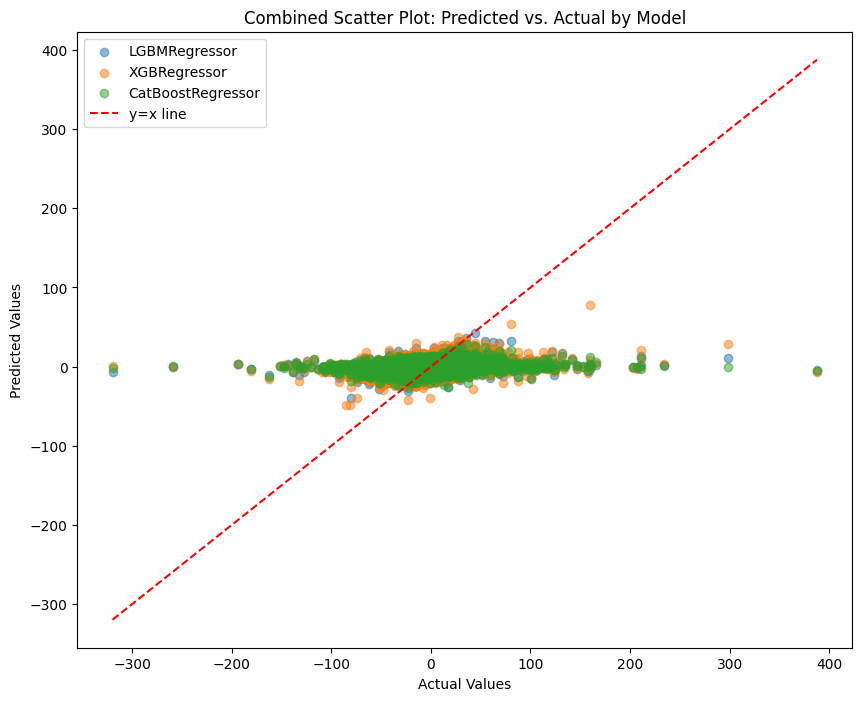

In [47]:
import matplotlib.pyplot as plt

# Initialize a dictionary to store the predictions for each model
predictions_by_model = {}

# Get predictions for each model
for model in models:
    model_name = model.__class__.__name__
    y_pred_test = model.predict(X_test)
    predictions_by_model[model_name] = y_pred_test

# Create a scatter plot for all models
plt.figure(figsize=(10, 8))

for model_name, y_pred_test in predictions_by_model.items():
    plt.scatter(Y_test, y_pred_test, alpha=0.5, label=model_name)

plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], linestyle='--', color='red', label='y=x line')

plt.title("Combined Scatter Plot: Predicted vs. Actual by Model")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()

plt.show()

#### Next steps
- CV Grid search on all three models. Analyze their optimized score